In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
plt.style.use('seaborn')


In [4]:
def load_data():
    train_synth = pd.read_csv('./playground-series-s3e2/train.csv')
    train_synth['data_type'] = 'synth'
    test_synth = pd.read_csv('./playground-series-s3e2/test.csv')
    train_real = pd.read_csv('./healthcare-dataset-stroke-data.csv')
    train_real['data_type'] = 'real'
    print(train_real.shape, train_synth.shape, test_synth.shape)
    train =  pd.concat([train_real, train_synth]).reset_index()
    train = train.drop(['id', 'index'], axis=1)
    return train, test_synth


def plot_var_stroke(var):
    stroke_gender = train.groupby('gender')['stroke'].mean()

    plt.bar(stroke_gender.index, stroke_gender, color=['#f8766d', '#00bfc4'])
    plt.title('Strokes among Males and Females', fontsize=15)
    plt.ylabel('Stroke', fontsize=15)
    plt.xlabel('Gender', fontsize=15)
    
    
def preprocess(df):
    df.loc[df['gender'] == 'Other', 'gender']= 'Male'
    df['age'] = df['age'].astype(int)

    ages = [0, 34, 54, 74, 99]
    age_groups = pd.cut(df['age'], ages, include_lowest=True, labels=['0-34', '35-54', '55-74', '75-99'])
    df['age_groups'] = age_groups
    df['work_type'] = df['work_type'].replace({'Private': 'pvt', 'Self-employed': 'se', 'children':'ch',
                        'Govt_job': 'gvt', 'Never_worked':'none'})
    df['weight'] = pd.cut(df['bmi'], [0, 18.5, 24.9, 29, 100], include_lowest=True,
                          labels=['underweight', 'healthy', 'overweight', 'obese'])
    df['glucose-cat'] = pd.cut(df['avg_glucose_level'], [0, 100, 185, 228, 271], include_lowest=True, 
                              labels=['0-100', '100-185', '185-228', '228-271'])
    return df



In [5]:
train, test = load_data()

(5110, 13) (15304, 13) (10204, 11)


In [6]:
train.shape

(20414, 12)

In [7]:
train1 = train.copy()
train1 = preprocess(train1)
test1 = test.copy()
test1 = preprocess(test1)

# plotting all variables

Text(0.5, 0, 'Stroke')

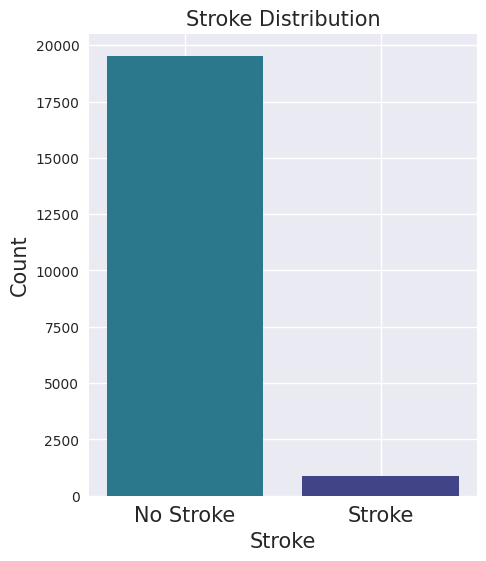

In [8]:
stroke = train1.stroke.astype(str)
stroke = stroke.value_counts()
plt.figure(figsize=(5, 6))
plt.bar(stroke.index, stroke, color=['#2b788d', '#414486'])
plt.xticks([0, 1], ['No Stroke', 'Stroke'], fontsize=15)    
plt.title('Stroke Distribution', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Stroke', fontsize=15)
# plt.savefig('./figures/stroke_dist.png', bbox_inches='tight', dpi=500)

Text(0.5, 0, 'Age')

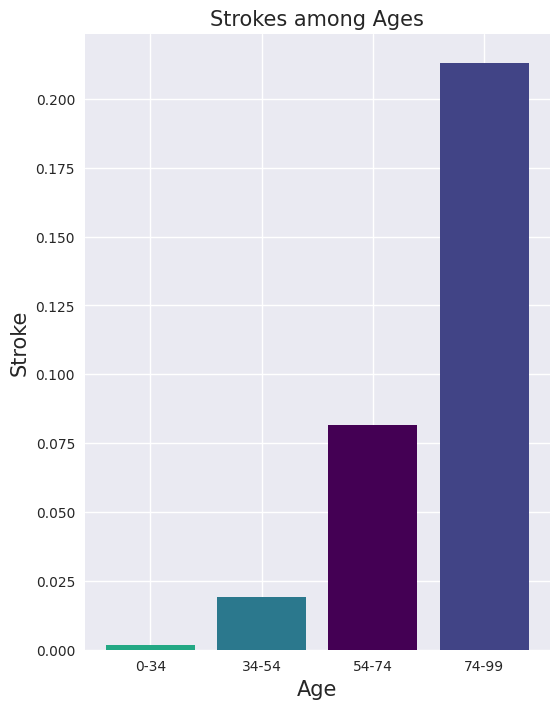

In [9]:
stroke_age = train1.groupby('age_groups')['stroke'].mean()
plt.figure(figsize=(6, 8))
age_groups = ['0-34', '34-54', '54-74',
       '74-99']
plt.bar(age_groups, stroke_age,
        color=['#23a884', '#2b788d', '#440054', '#414486'])
plt.title('Strokes among Ages', fontsize=15)
plt.ylabel('Stroke', fontsize=15)
plt.xlabel('Age', fontsize=15)
# plt.savefig('./figures/stroke_age.png', bbox_inches='tight', dpi=500)

In [10]:
train1.gender.value_counts()

gender
Female    12440
Male       7974
Name: count, dtype: int64

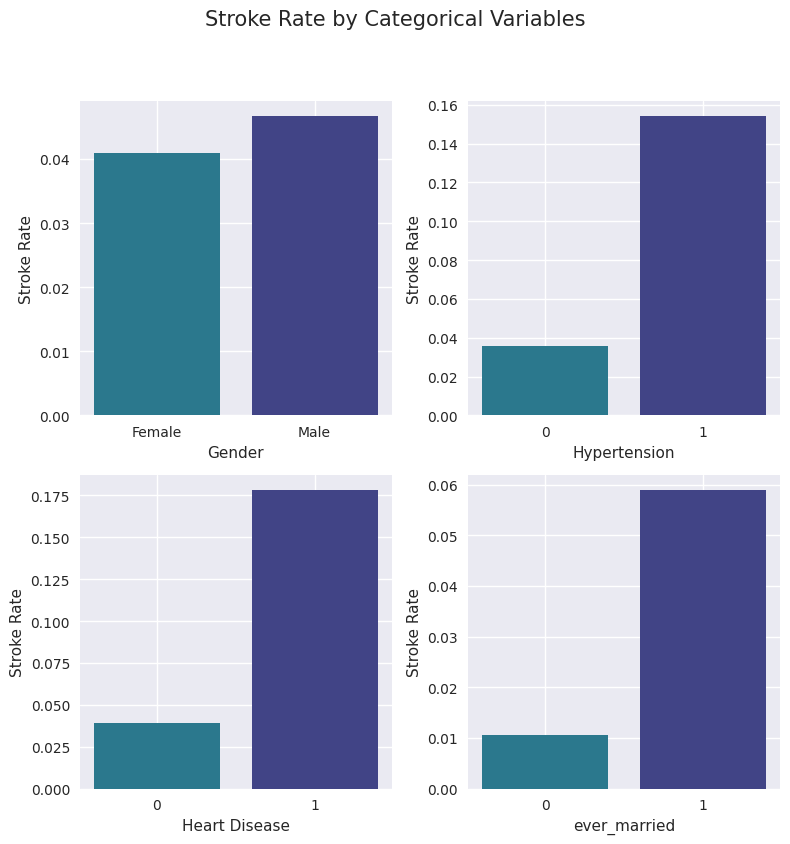

In [11]:
fig, (row1, row2) = plt.subplots(2,2, figsize=(8, 8))

#gender 
stroke_gender = train1.groupby('gender')['stroke'].mean()
row1[0].bar(stroke_gender.index, stroke_gender, color=['#2b788d', '#414486'])
row1[0].set_xlabel('Gender')

# hypertension
stroke_hypertension = train1.groupby('hypertension')['stroke'].mean()
row1[1].bar(['0','1'], stroke_hypertension, color=['#2b788d', '#414486'])
row1[1].set_xlabel('Hypertension')

#heart_disease
stroke_heartds = train1.groupby('heart_disease')['stroke'].mean()
row2[0].bar(['0','1'], stroke_heartds, color=['#2b788d', '#414486'])
row2[0].set_xlabel('Heart Disease')

#ever_married
stroke_married = train1.groupby('ever_married')['stroke'].mean()
row2[1].bar(['0','1'], stroke_married, color=['#2b788d', '#414486'])
row2[1].set_xlabel('ever_married')

#set the title for the whole plot put the title in the middle
fig.suptitle('Stroke Rate by Categorical Variables', fontsize=15, y=1.05)


# set the y label as stroke rate
for row in [row1, row2]:
    for col in row:
        col.set_ylabel('Stroke Rate')
plt.tight_layout()
# plt.savefig('./figures/stroke_rate.png', bbox_inches='tight', dpi=500)

# Modelling

In [24]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split



In [25]:
def generate_features(df):
    df['age/bmi'] = df.age / df.bmi
    df['age*bmi'] = df.age * df.bmi
    df['bmi/prime'] = df.bmi / 25
    df['obesity'] = df.avg_glucose_level * df.bmi / 1000
    df['blood_heart']= df.hypertension*df.heart_disease
    df.loc[df['smoking_status']=='Unknown', 'smoking_status'] = 'never smoked'    

    return df

In [26]:
def preprocess(train_df, test_df=None):
    cols = ['ever_married', 'gender', 'work_type', 'Residence_type', 'smoking_status']
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    ohe.fit(train_df[cols])
    train_ohe = pd.DataFrame(ohe.transform(train_df[cols]))
    train_ohe.index = train_df.index
    # add column names to the one-hot encoded features
    ohe_cols = ohe.get_feature_names_out(cols)
    train_ohe.columns = ohe_cols
    train_df.drop(columns=cols, inplace=True)
    train_df = pd.concat([train_df, train_ohe], axis=1)

    cols_drop = ['age_groups', 'weight', 'glucose-cat']    
    train_df = train_df.drop(cols_drop + ['data_type'], axis=1)
    train_df.dropna(inplace=True)

    if test_df is not None:

        test_ohe = pd.DataFrame(ohe.transform(test_df[cols]))
        test_ohe.index = test_df.index
        test_ohe.columns = ohe_cols
        test_df = pd.concat([test_df, test_ohe], axis=1)
        test_df = test_df.drop(columns=cols + cols_drop + ['id'], axis=1)
        return train_df, test_df
    return train_df

In [27]:
train2 = train1.copy()
test2 = test1.copy()
train2 = generate_features(train2)
test2 = generate_features(test2)
train2, test2 = preprocess(train2, test_df=test2)


In [28]:
X = train2.drop(columns=['stroke'])
y = train2.stroke

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [31]:
# create an ensemble of xgboost and lightgbm
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


# define the base models
models = list()

xgb = XGBClassifier(gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=50)
lgbm = LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=10)
models.append(('xgb', xgb))
models.append(('lgbm', lgbm))

# define the voting ensemble
ensemble = VotingClassifier(estimators=models, voting='soft')
# evaluate the ensemble
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(ensemble, X, y, scoring='roc_auc', n_jobs=-1, error_score='raise')
# report performance
print('Mean ROC AUC: %.3f' % np.mean(n_scores))

# fit the model on the whole dataset
ensemble.fit(X, y)

# make a prediction for one example
yhat = ensemble.predict_proba(test2)[:, 1]

# save the prediction to csv
submission = pd.DataFrame({'id': test1.id, 'stroke': yhat})
submission.to_csv('submission.csv', index=False)

Mean ROC AUC: 0.875
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 841, number of negative: 19372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1647
[LightGBM] [Info] Number of data points in the train set: 20213, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041607 -> initscore=-3.136992
[LightGBM] [Info] Start training from score -3.136992


In [32]:
for alg in ensemble.named_estimators_:
    clf = ensemble.named_estimators_[alg]
    

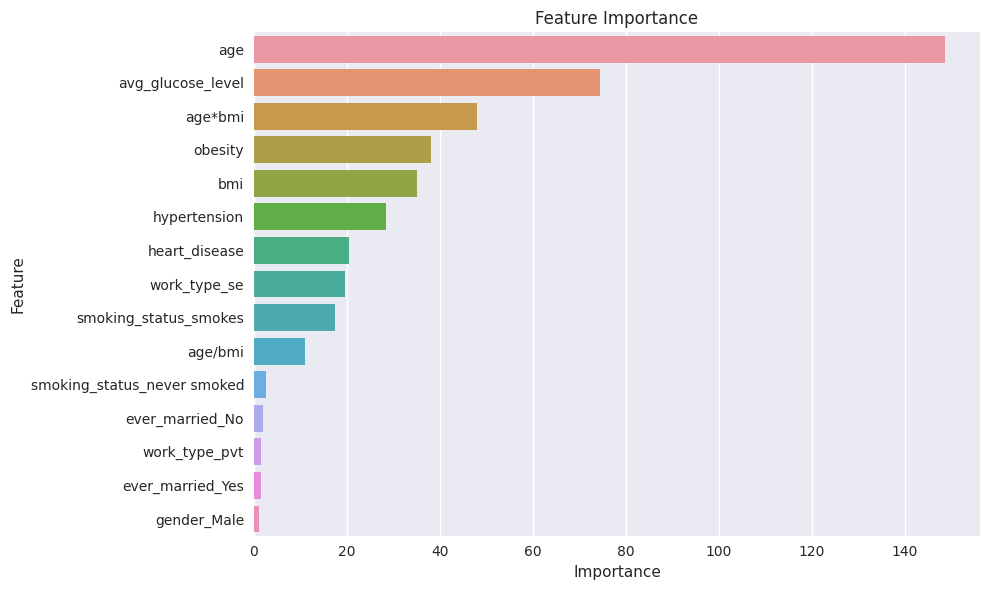

In [33]:
for alg in ensemble.named_estimators_:
    if alg == 'xgb':
        xgb = ensemble.named_estimators_[alg]
    else:
        lgbm = ensemble.named_estimators_[alg]
    
xgb_feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': xgb.feature_importances_})
lgbm_feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': lgbm.feature_importances_})

feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': (xgb.feature_importances_ + lgbm.feature_importances_)/2})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

#plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp[:15])
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=500)
